In [54]:
import pymongo, pandas as pd, scipy.stats, matplotlib.pyplot as plt, sys
sys.path.append('../../../scripts')
import utils

# First Hypothesis

In the following notebook it will be analyzed the following hypothesis:
 - **Players that liked a video game, tend to continue playing it**

## Players that liked a video game, tend to continue playing it

### Import json reviews dataset & select relevant features to perform the analysis

In [55]:
# Connect to the local MongoDB instance and select the database used as repository for the small reviews dataset
mongo = pymongo.MongoClient()
mongo_db = mongo.final_project
# Load the reviews from the small_reviews collection of the final_project MongoDB database
small_reviews_df = pd.DataFrame(list(mongo_db.small_reviews_filtered.find({}, {'_id': False})))
mongo.close() #Close the connection

In [56]:
# Print a few rows of the small reviews dataset to verify their correctness
small_reviews_df

,base_review_id,steamid,appid,voted_up,votes_up,votes_funny,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,review,unix_timestamp_created,unix_timestamp_updated
0,18,76561198058159765,204100,True,0,0,0.000000,356,336,61,3,good\n,1618048279,1618048279
1,25,76561198126769984,204100,True,0,0,0.000000,477,97,41,23,"I beat this game 5 times on ps3, when i saw th...",1617410356,1617410356
2,22,76561198372464367,204100,True,0,0,0.000000,1684,1581,135,8,one of the best 3rd person shooting game,1617507118,1617507118
3,3,76561198255525846,204100,True,0,0,0.000000,69,69,27,1,I enjoy the game. Played it to 100% on PS3 an...,1619035215,1619035215
4,27,76561198090877508,204100,True,0,0,0.000000,421,421,87,6,me cague a tiro con brazucas y me empastille a...,1617402322,1617402322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307951,77309412962,76561198945436777,598980,False,2,28,0.198423,159,41,1,1,Excuse me kind programmer this game isnt worki...,1553811131,1553811131
307952,77309413004,76561198030747313,597970,True,1,0,0.470299,1631,596,300,2,"Really fun, great game design. I like the char...",1500990434,1500990434
307953,77309413007,76561197985682990,597970,True,1,0,0.502488,1422,1402,61,3,"I just bought this game, I like it, it has a l...",1497200643,1497200643
307954,77309413014,76561197991784193,597970,True,4,0,0.543026,551,551,651,15,Age of Rivals is a really interesting card gam...,1489890474,1489890474


#### Metrics (playtime_after_review)

In order to perform this analysis we are interested on obtaining how much time (minutes in that case) a player continue playing a videogame after its review
 - **playtime_after_review = playtime_forever - playtime_at_review**

In [59]:
# Add a new column with the difference between the total playtime and the playtime at review
small_reviews_df['playtime_after_review'] = small_reviews_df['playtime_forever'] - small_reviews_df['playtime_at_review']

In [60]:
# Analyze some base statistics of the small reviews dataset with the new playtime_after_review column
small_reviews_df.describe()

,base_review_id,steamid,appid,votes_up,votes_funny,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,unix_timestamp_created,unix_timestamp_updated,playtime_after_review
count,3.079560e+05,3.079560e+05,3.079560e+05,307956.000000,3.079560e+05,307956.000000,3.079560e+05,3.079560e+05,307956.000000,307956.000000,3.079560e+05,3.079560e+05,3.079560e+05
mean,2.535183e+10,7.656120e+16,3.046442e+05,2.382597,1.255211e+05,0.197043,1.532822e+04,8.115091e+03,198.299491,17.278374,1.526152e+09,1.529936e+09,7.213129e+03
std,2.110916e+10,2.861591e+08,2.137097e+05,34.032991,2.321834e+07,0.251234,4.141695e+04,2.505509e+04,372.072852,60.423659,6.972482e+07,6.887861e+07,2.468015e+04
min,3.000000e+00,7.656120e+16,1.000000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,1.287186e+09,1.287218e+09,0.000000e+00
25%,8.590088e+09,7.656120e+16,2.040300e+05,0.000000,0.000000e+00,0.000000,7.060000e+02,3.790000e+02,37.000000,2.000000,1.475266e+09,1.480032e+09,4.200000e+01
50%,1.718033e+10,7.656120e+16,2.827600e+05,0.000000,0.000000e+00,0.000000,2.691000e+03,1.296000e+03,99.000000,5.000000,1.542850e+09,1.546268e+09,6.290000e+02
75%,4.294974e+10,7.656120e+16,4.180825e+05,1.000000,0.000000e+00,0.496141,1.136200e+04,5.153250e+03,226.000000,15.000000,1.585906e+09,1.587955e+09,4.146000e+03
max,7.730941e+10,7.656120e+16,1.051310e+06,8979.000000,4.294967e+09,0.971397,2.636067e+06,1.388750e+06,19078.000000,5236.000000,1.619149e+09,1.619149e+09,2.634424e+06


In [61]:
# Split the dataset in two parts: select the playtime after review for negative reviews and positive reviews
voted_up_series = small_reviews_df['voted_up']
pos_playtime_after_review_series = small_reviews_df[voted_up_series]['playtime_after_review']
neg_playtime_after_review_series = small_reviews_df[~voted_up_series]['playtime_after_review']

### Correlation tests

#### Mann–Whitney U test

The test is expected to reject the null hypothesis, i.e., to conclude that the distribution underlying *pos_playtime_after_review_series* is stochastically greater than the distribution underlying *neg_playtime_after_review_series*, i.e., F(u) < G(u) for all u (if F is the cumulative distribution of *pos_playtime_after_review* and G is the cumulative distribution of *neg_playtime_after_review*)

In [62]:
mann_whitney_u_stat, p_value = scipy.stats.mannwhitneyu(pos_playtime_after_review_series, neg_playtime_after_review_series, alternative='greater')

# Print the test result
null_hypothesis_stat = pos_playtime_after_review_series.size * neg_playtime_after_review_series.size * 0.5
print(f'Mann–Whitney U test statistic under the null hypothesis: {null_hypothesis_stat:.3f}.')
print(f'Computed Mann–Whitney U test statistic: {mann_whitney_u_stat:.3f}, p-value: {p_value:.3f}.')
if p_value > 0.05:
    print('\nDo not reject the null hypothesis.')
else:
    print('\nReject the null hypothesis.')

Mann–Whitney U test statistic under the null hypothesis: 5405880497.500.
Computed Mann–Whitney U test statistic: 7116005536.500, p-value: 0.000.

Reject the null hypothesis.


In [63]:
# Check the mean playtime after review values for positive and negative reviews
print(f'Mean playtime after review for positive reviews: {pos_playtime_after_review_series.mean():.3f}.')
print(f'Mean playtime after review for negative reviews: {neg_playtime_after_review_series.mean():.3f}.')

# Check the median playtime after review values for positive and negative reviews
print(f'\nMedian playtime after review for positive reviews: {pos_playtime_after_review_series.median():.3f}.')
print(f'Median playtime after review for negative reviews: {neg_playtime_after_review_series.median():.3f}.')

Mean playtime after review for positive reviews: 7662.445.
Mean playtime after review for negative reviews: 4238.387.

Median playtime after review for positive reviews: 774.000.
Median playtime after review for negative reviews: 57.000.


### Show boxplots

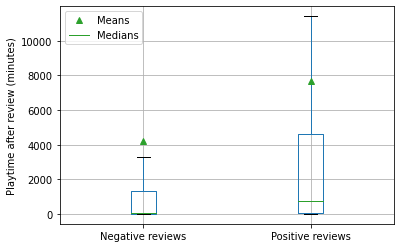

In [64]:
# Plot a boxplot of the playtime after review for positive and negative reviews
playtime_after_review_boxplot = pd.DataFrame({
    'Negative reviews': neg_playtime_after_review_series,
    'Positive reviews': pos_playtime_after_review_series
}).boxplot(showfliers=False, showmeans=True, return_type='dict')
plt.legend([playtime_after_review_boxplot['means'][0], playtime_after_review_boxplot['medians'][0]], ['Means', 'Medians'])
plt.ylabel('Playtime after review (minutes)');

#### Spearman's Rank Correlation Coefficient

Since PySpark does not allow to perform the Mann-Whitney U test, in the following cells a simpler correlation test is carried out. A positive correlation coefficient between the playtime after review and the ordered negative/positive reviews class labels (0 = negative review, 1 = positive review) suggests that players who liked a game tend to play more at that game than players who did not like it, after making the review.

In [65]:
# Calculate the Spearman's r correlation coefficient and its p-value: the test is expected to reject the
# null hypothesis, i.e., to conclude that there is a positive correlation between voted_up and
# playtime_after_review
spearman_r_stat, p_value = scipy.stats.spearmanr(voted_up_series.astype(int), small_reviews_df['playtime_after_review'], alternative='greater')

# Print the test result
print(f'Computed Spearman\'s r correlation coefficient: {spearman_r_stat:.3f}, p-value: {p_value:.3f}.')
if p_value > 0.05:
    print('\nDo not reject the null hypothesis.')
else:
    print('\nReject the null hypothesis.')

Computed Spearman's r correlation coefficient: 0.185, p-value: 0.000.

Reject the null hypothesis.


### See the effect size

How can we be sure that there is a real difference between the two groups (the playtime of who liked a game and who not) and that we do not fall into the significance fallacy (statistical significance does not necessary mean reality significance)?<br>
The *Cohen's d* has been used specifically for that purpose.

In [66]:
# Compute and print the Cohen's d estimator of the effect size
cohen_d = utils.cohen_d(pos_playtime_after_review_series, neg_playtime_after_review_series)
print("Cohen's d:", round(cohen_d, 2))

Cohen's d: 0.14


The effect size obtained is generally considered small: this means that the difference between the two groups is statistically significant, but it is probably difficult to detect without recurring to statistical tools applied to large samples (***statistical significance* vs *real significance*** problem).